openslr_35_data/utt_spk_text.tsv: 100%|██████████| 11.5M/11.5M [00:01<00:00, 11.7MB/s]


asr_javanese_0.zip: 100%|██████████| 1.12G/1.12G [00:38<00:00, 30.8MB/s]


Extracting asr_javanese_0.zip...
Extracted and cleaned up asr_javanese_0.zip



openslr_36_data/utt_spk_text.tsv: 100%|██████████| 14.9M/14.9M [00:01<00:00, 13.0MB/s]


asr_sundanese_0.zip: 100%|██████████| 1.33G/1.33G [00:43<00:00, 33.2MB/s]


Extracting asr_sundanese_0.zip...
Extracted and cleaned up asr_sundanese_0.zip

Cloning Indonesian dataset...

Processing Javanese...

Processing Sundanese...

Processing Indonesian...

Sample of extracted features:
   mean_zcr   std_zcr  mean_ste   std_ste  mean_pitch  std_pitch  min_pitch  \
0  0.162477  0.134843  0.001700  0.003045   17.726560  75.065392        0.0   
1  0.156274  0.081993  0.001011  0.001727   13.959776  59.974829        0.0   
2  0.178088  0.085999  0.001864  0.002769   17.407609  63.244780        0.0   
3  0.169351  0.137118  0.009209  0.017437   32.959540  95.449184        0.0   
4  0.131518  0.109619  0.002383  0.003525   14.931919  61.368985        0.0   

    max_pitch  voiced_ratio     label  ...  mfcc9_mean  mfcc9_std  \
0  363.636364      0.053191  Javanese  ...  -12.944571  14.259805   
1  296.296296      0.051724  Javanese  ...    5.025900   9.756617   
2  285.714286      0.070776  Javanese  ...    2.494231  12.207686   
3  355.555556      0.107266  Java

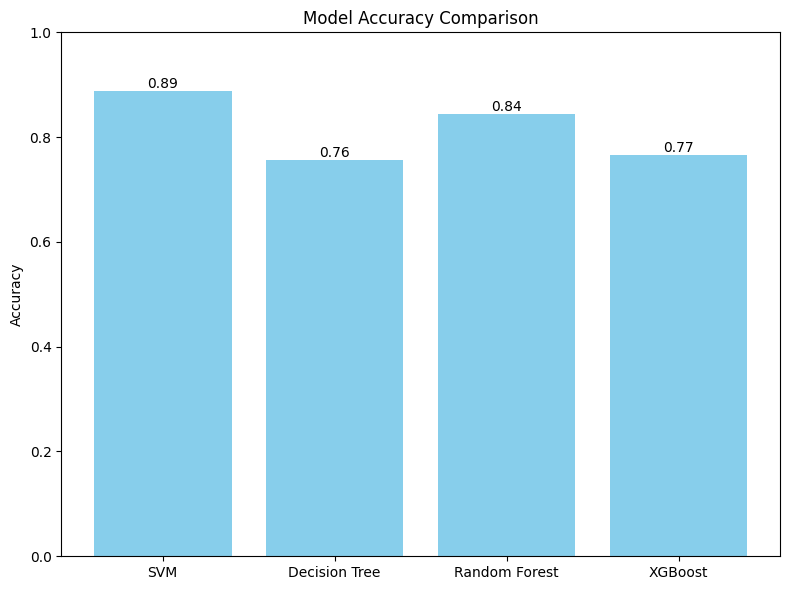

In [ ]:
import numpy as np
np.complex = complex

import os
import zipfile
import requests
import subprocess
from tqdm import tqdm
import librosa
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import warnings

warnings.filterwarnings("ignore")

# --- Download and extract OpenSLR ---
def download_with_progress(url, filename):
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    with open(filename, 'wb') as file, tqdm(desc=filename, total=total_size, unit='B', unit_scale=True, unit_divisor=1024) as pbar:
        for chunk in response.iter_content(chunk_size=8192):
            if chunk:
                file.write(chunk)
                pbar.update(len(chunk))

def download_openslr(dataset_id, prefix, num_files=1):
    assert dataset_id in [35, 36], "Only OpenSLR 35 and 36 supported"
    base_url = f"https://www.openslr.org/resources/{dataset_id}/"
    output_dir = f"openslr_{dataset_id}_data"
    os.makedirs(output_dir, exist_ok=True)

    transcript_url = f"{base_url}utt_spk_text.tsv"
    print("Downloading transcript file...")
    download_with_progress(transcript_url, f"{output_dir}/utt_spk_text.tsv")

    file_suffixes = list(map(str, range(10))) + list("abcdef")
    for i in range(min(num_files, 16)):
        suffix = file_suffixes[i]
        zip_filename = f"{prefix}_{suffix}.zip"
        url = f"{base_url}{zip_filename}"
        print(f"Downloading {zip_filename} ({i+1}/{num_files})...")
        download_with_progress(url, zip_filename)
        print(f"Extracting {zip_filename}...")
        with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
            zip_ref.extractall(output_dir)
        os.remove(zip_filename)
        print(f"Extracted and cleaned up {zip_filename}")
    return output_dir

def clone_indonesian_dataset():
    repo_url = "https://github.com/Nexdata-AI/359-Hours-Indonesian-Speech-Data-by-Mobile-Phone_Reading.git"
    target_dir = "indonesian_dataset"
    if not os.path.exists(target_dir):
        subprocess.run(["git", "clone", repo_url, target_dir], check=True)
    return target_dir

def find_audio_files(base_dir):
    files = []
    for root, _, filenames in os.walk(base_dir):
        for f in filenames:
            if f.endswith(('.wav', '.flac')):
                files.append(os.path.join(root, f))
    return files

# --- Parameters ---
FRAME_SIZE = 0.025
FRAME_SHIFT = 0.01
SR = 16000

def segment_audio_to_frames(audio, sr=SR):
    frame_length = int(FRAME_SIZE * sr)
    hop_length = int(FRAME_SHIFT * sr)
    num_frames = 1 + (len(audio) - frame_length) // hop_length
    frames = [audio[i * hop_length : i * hop_length + frame_length] for i in range(num_frames)]
    return np.array(frames)

# --- Feature Extractor with MFCC ---
class FeatureExtractor:
    def __init__(self, sr=SR):
        self.sr = sr

    def extract_zcr(self, audio_frame):
        return np.mean(np.diff(np.sign(audio_frame)) != 0)

    def extract_ste(self, audio_frame):
        return np.sum(audio_frame**2) / len(audio_frame)

    def extract_pitch(self, audio_frame):
        autocorr = np.correlate(audio_frame, audio_frame, mode="full")
        autocorr = autocorr[len(autocorr)//2:]
        peak = np.argmax(autocorr[1:]) + 1
        if peak == 0 or autocorr[peak] < 0.1:
            return 0
        pitch = self.sr / peak
        return pitch if 50 < pitch < 400 else 0

    def extract_features_from_frames(self, frames):
        zcrs, stes, pitches = [], [], []
        for frame in frames:
            zcrs.append(self.extract_zcr(frame))
            stes.append(self.extract_ste(frame))
            pitches.append(self.extract_pitch(frame))
        return pd.DataFrame({
            "zcr": zcrs,
            "ste": stes,
            "pitch": pitches
        })

    def extract_mfcc_stats(self, audio):
        mfcc = librosa.feature.mfcc(y=audio, sr=self.sr, n_mfcc=13)
        mfcc_means = np.mean(mfcc, axis=1)
        mfcc_stds = np.std(mfcc, axis=1)
        mfcc_features = {}
        for i in range(13):
            mfcc_features[f"mfcc{i+1}_mean"] = mfcc_means[i]
            mfcc_features[f"mfcc{i+1}_std"] = mfcc_stds[i]
        return mfcc_features

# --- Classifier ---
class LanguageClassifier:
    def __init__(self, label_encoder):
        self.scaler = StandardScaler()
        self.label_encoder = label_encoder

    def train_and_evaluate(self, X, y):
        X_scaled = self.scaler.fit_transform(X)
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, stratify=y, random_state=42)
        models = {
            "SVM": SVC(),
            "Decision Tree": DecisionTreeClassifier(),
            "Random Forest": RandomForestClassifier(),
            "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
        }
        accuracies = {}
        print("\n--- Language Classification Results ---\n")
        for name, model in models.items():
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            acc = accuracy_score(y_test, y_pred)
            accuracies[name] = acc
            print(f"{name} Accuracy: {acc:.4f}")
            print(classification_report(y_test, y_pred, target_names=self.label_encoder.classes_))
        self.plot_accuracies(accuracies)

    def plot_accuracies(self, accuracies):
        plt.figure(figsize=(8, 6))
        model_names = list(accuracies.keys())
        scores = list(accuracies.values())
        bars = plt.bar(model_names, scores, color='skyblue')
        plt.ylim(0, 1)
        plt.ylabel("Accuracy")
        plt.title("Model Accuracy Comparison")
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2.0, height, f"{height:.2f}", ha='center', va='bottom')
        plt.tight_layout()
        plt.show()

# --- Main ---
if __name__ == "__main__":
    print("\nDownloading OpenSLR 35 (Javanese)...")
    javanese_path = download_openslr(35, "asr_javanese", num_files=1)
    javanese_files = find_audio_files(javanese_path)

    print("\nDownloading OpenSLR 36 (Sundanese)...")
    sundanese_path = download_openslr(36, "asr_sundanese", num_files=1)
    sundanese_files = find_audio_files(sundanese_path)

    print("\nCloning Indonesian dataset...")
    indo_path = clone_indonesian_dataset()
    indo_files = find_audio_files(indo_path)

    extractor = FeatureExtractor(sr=SR)
    all_data = []
    NUM_SAMPLES_PER_LANG = 10000

    for label, file_list in zip(["Javanese", "Sundanese", "Indonesian"], [javanese_files, sundanese_files, indo_files]):
        print(f"\nProcessing {label}...")
        for audio_path in file_list[:NUM_SAMPLES_PER_LANG]:
            try:
                audio, sr = librosa.load(audio_path, sr=SR)
                frames = segment_audio_to_frames(audio, sr)
                frame_df = extractor.extract_features_from_frames(frames)
                voiced_ratio = np.mean(frame_df["pitch"] > 0)
                if voiced_ratio < 0.05:
                    continue

                mfcc_features = extractor.extract_mfcc_stats(audio)
                base_features = {
                    "mean_zcr": frame_df["zcr"].mean(),
                    "std_zcr": frame_df["zcr"].std(),
                    "mean_ste": frame_df["ste"].mean(),
                    "std_ste": frame_df["ste"].std(),
                    "mean_pitch": frame_df["pitch"].mean(),
                    "std_pitch": frame_df["pitch"].std(),
                    "min_pitch": frame_df["pitch"].min(),
                    "max_pitch": frame_df["pitch"].max(),
                    "voiced_ratio": voiced_ratio,
                    "label": label
                }
                base_features.update(mfcc_features)
                all_data.append(base_features)
            except Exception as e:
                print(f"Failed to process {audio_path}: {e}")

    df = pd.DataFrame(all_data)
    print("\nSample of extracted features:")
    print(df.head())

    X = df.drop("label", axis=1)
    le = LabelEncoder()
    y = le.fit_transform(df["label"])

    classifier = LanguageClassifier(le)
    classifier.train_and_evaluate(X, y)